In [1]:
from sympy import *
init_printing()

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

# Generate Ex Data

## Setup four scaler function with 4D input

In [2]:
w, x, y, z=symbols('w, x, y, z')
f1=Function('f_1')(w, x, y, z)
f2=Function('f_2')(w, x, y, z)
f3=Function('f_3')(w, x, y, z)
f4=Function('f_4')(w, x, y, z)

In [3]:
f1Eq=Eq(f1, 1*w+2*x+3*y+4*z)
f2Eq=Eq(f2, 4*w+3*x+2*y+1*z)
f3Eq=Eq(f3, 2*w+1*x+3*y+4*z)
f4Eq=Eq(f4, 1*w+2*x+4*y+3*z)
f1Eq, f2Eq, f3Eq, f4Eq

## Convert the sympy equations to numpy functions with sympy's `lambdify`

In [4]:
f1N=lambdify((w, x, y, z), f1Eq.rhs, dummify=False)
f2N=lambdify((w, x, y, z), f2Eq.rhs, dummify=False)
f3N=lambdify((w, x, y, z), f3Eq.rhs, dummify=False)
f4N=lambdify((w, x, y, z), f4Eq.rhs, dummify=False)
#test
f1N(1,1,1,1), f2N(1,1,1,1), f3N(1,1,1,1), f4N(1,1,1,1)

## create the numerical simulation domain

In [5]:
wN=np.linspace(0, 10)
xN=np.copy(wN); yN=np.copy(wN); zN=np.copy(wN)

## bind the domain to a Dataset coordinates 

In [6]:
Data=xr.Dataset(coords={
    'w':wN, 'x':xN, 'y':yN, 'z':zN
})
Data

<xarray.Dataset>
Dimensions:  (w: 50, x: 50, y: 50, z: 50)
Coordinates:
  * w        (w) float64 0.0 0.2041 0.4082 0.6122 0.8163 1.02 1.224 1.429 ...
  * x        (x) float64 0.0 0.2041 0.4082 0.6122 0.8163 1.02 1.224 1.429 ...
  * y        (y) float64 0.0 0.2041 0.4082 0.6122 0.8163 1.02 1.224 1.429 ...
  * z        (z) float64 0.0 0.2041 0.4082 0.6122 0.8163 1.02 1.224 1.429 ...
Data variables:
    *empty*

## Throw the simulation domain at the scaler functions and bind the results to the Dataset

In [7]:
Data['f1']=([*Data.dims.keys()], f1N(*np.meshgrid(*Data.coords.values())))
Data['f2']=([*Data.dims.keys()], f2N(*np.meshgrid(*Data.coords.values())))
Data['f3']=([*Data.dims.keys()], f3N(*np.meshgrid(*Data.coords.values())))
Data['f4']=([*Data.dims.keys()], f4N(*np.meshgrid(*Data.coords.values())))
Data

<xarray.Dataset>
Dimensions:  (w: 50, x: 50, y: 50, z: 50)
Coordinates:
  * w        (w) float64 0.0 0.2041 0.4082 0.6122 0.8163 1.02 1.224 1.429 ...
  * x        (x) float64 0.0 0.2041 0.4082 0.6122 0.8163 1.02 1.224 1.429 ...
  * y        (y) float64 0.0 0.2041 0.4082 0.6122 0.8163 1.02 1.224 1.429 ...
  * z        (z) float64 0.0 0.2041 0.4082 0.6122 0.8163 1.02 1.224 1.429 ...
Data variables:
    f1       (w, x, y, z) float64 0.0 0.8163 1.633 2.449 3.265 4.082 4.898 ...
    f2       (w, x, y, z) float64 0.0 0.2041 0.4082 0.6122 0.8163 1.02 1.224 ...
    f3       (w, x, y, z) float64 0.0 0.8163 1.633 2.449 3.265 4.082 4.898 ...
    f4       (w, x, y, z) float64 0.0 0.6122 1.224 1.837 2.449 3.061 3.673 ...

# What holoviews should do

So first off we are going to keep time and 3D on hold lets just use 2D viewing viewing ex

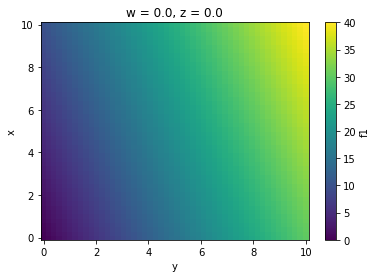

In [8]:
Data['f1'][dict(w=0, z=0)].plot()

So what I would like to do is import the Dataset into holoviews so that holoviews is aware of the set names and the dimensions and their corresponding coordinate values.

Then to visualize the output I want to be able to control which of, in this case, 4 dimensions,  I want as the kdims and the vdims. With that I have a radial button set of all the xarrays dims where 2 (or later on 3) have are always selected to set which of the xarrys dims are the vdims and the rest become kdims that are treated as parameters

The resulting kdims generate a set of slider widgets matching the values in the xarryas dimensions coordinate values

And finally two options for viewing.
1. a drop-down widget of the set names that whichever is selected is the set being viewed
2. have the option to select multiple sets that generate a shingling of the above imshows

# Prototype examples

### shingling and kdims from xarray ex

In [9]:
#https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearestLoc(array,value):
    if value!=None:
        idx = (np.abs(array-value)).argmin()
    else:
        idx=None
    
    return idx

In [10]:
wloc=find_nearestLoc(wN, 5)
zloc=find_nearestLoc(zN, 4)
wloc, zloc

(24, 20)

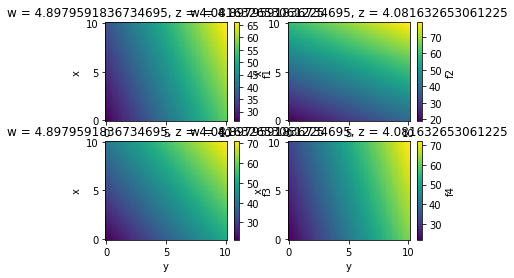

In [11]:
 
fig, [[ax1, ax2], [ax3, ax4]]=plt.subplots(nrows=2, ncols=2)

Data['f1'][dict(w=wloc, z=zloc)].plot(ax=ax1)
Data['f2'][dict(w=wloc, z=zloc)].plot(ax=ax2)
Data['f3'][dict(w=wloc, z=zloc)].plot(ax=ax3)
Data['f4'][dict(w=wloc, z=zloc)].plot(ax=ax4);
# yes I know the spaceing; its a prototype


In [12]:
def kDimSelect_proto(wTarget=None, xTarget=None, yTarget=None, zTarget=None):
    
    # test for two only
    #count the Nones
    T=sum(i is not None for i in [wTarget, xTarget, yTarget, zTarget])
    if T!=2:
        raise ValueError(f'there needs to be 2 Nones not {T}')
    
    #find the locations of targets
    wloc=find_nearestLoc(wN, wTarget)
    xloc=find_nearestLoc(xN, xTarget)
    yloc=find_nearestLoc(yN, yTarget)
    zloc=find_nearestLoc(zN, zTarget)
    
    DataSelect={}
    for i, j in zip([*Data.dims.keys()], [wloc, xloc, yloc, zloc]):
        if j!=None:
            DataSelect={**DataSelect, **{i:j}}
            
    return DataSelect

In [13]:
kDimSelect_proto(wTarget=5, zTarget=4)

{'w': 24, 'z': 20}

In [14]:
#test error
kDimSelect_proto(wTarget=5, zTarget=4, yTarget=9)

ValueError: there needs to be 2 Nones not 3

In [15]:
def ShinglePlotXarraySets(kdim):
     
    fig, [[ax1, ax2], [ax3, ax4]]=plt.subplots(nrows=2, ncols=2)

    Data['f1'][kdim].plot(ax=ax1)
    Data['f2'][kdim].plot(ax=ax2)
    Data['f3'][kdim].plot(ax=ax3)
    Data['f4'][kdim].plot(ax=ax4);
    # yes I know the spaceing; its a prototype

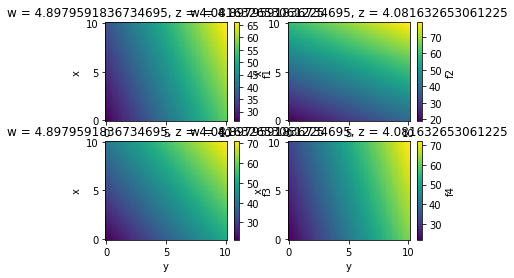

In [16]:
ShinglePlotXarraySets(kDimSelect_proto(wTarget=5, zTarget=4))

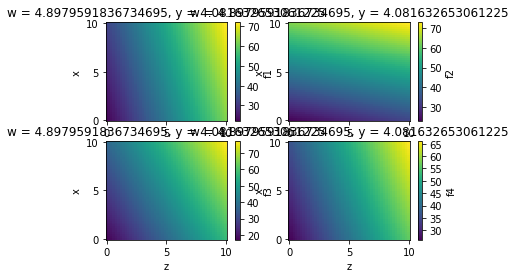

In [17]:
ShinglePlotXarraySets(kDimSelect_proto(wTarget=5, yTarget=4))

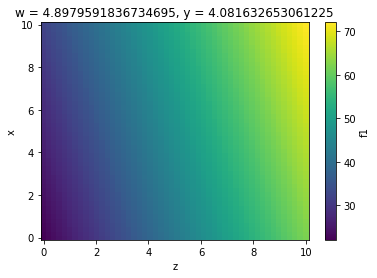

In [18]:
def SingleSetPlot(kdim, DataSet='f1'):
    Data[DataSet][kdim].plot()

SingleSetPlot(kDimSelect_proto(wTarget=5, yTarget=4))

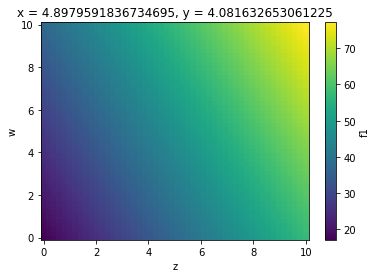

In [19]:
SingleSetPlot(kDimSelect_proto(xTarget=5, yTarget=4))

I can add widget prototypes but I think this is what is needed to get what I would like holoviews to do and a good starting code set